### requirements and dataset

In [80]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [81]:
df = pd.read_csv('dataset/loan_prediction.csv')
df.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


### Data Cleaning

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 67.2+ KB


In [83]:
df = df.drop('Loan_ID', axis=1)

In [84]:
print(df.isnull().sum())
print(df.shape)

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
(614, 12)


In [85]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [86]:
print(df.Gender.mode())
print(df.Married.mode())
print(df.Dependents.mode())
print(df.Self_Employed.mode())

0    Male
Name: Gender, dtype: object
0    Yes
Name: Married, dtype: object
0    0
Name: Dependents, dtype: object
0    No
Name: Self_Employed, dtype: object


In [87]:
# Fill missing values in categorical columns with mode
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

In [88]:
# Fill missing values in LoanAmount with the median
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

# Fill missing values in Loan_Amount_Term with the mode
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)

# Fill missing values in Credit_History with the mode
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [89]:
print(df.isnull().sum())
print(df.shape)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
(614, 12)


### exploratory analisys

In [90]:
# crosstab and value_count functions
def value_counts_summary(df, columns):
    """
    Receives a DataFrame and a list of columns to perform value_counts and 
    value_counts(normalize=True). Returns a DataFrame with absolute and 
    normalized counts, aligning unique variables across different columns.

    Args:
    - df: pd.DataFrame, the input DataFrame.
    - columns: list of str, names of the columns for performing value_counts.

    Returns:
    - pd.DataFrame, a DataFrame containing the count results.
    """
    results = []

    for col in columns:
        # Absolute value counts
        abs_counts = df[col].value_counts().reset_index()
        abs_counts.columns = ['Value', 'Absolute Count']
        
        # Normalized value counts
        norm_counts = df[col].value_counts(normalize=True * 100).map('{:.2f}%'.format).reset_index()
        norm_counts.columns = ['Value', 'Normalized Count']
        
        # Merge absolute and normalized counts
        summary = pd.merge(abs_counts, norm_counts, on='Value', how='outer')
        summary['Column'] = col  # Add the name of the original column
        
        # Add normalized count as 0 for missing values
        summary['Normalized Count'].fillna(0, inplace=True)
        
        results.append(summary)

    # Concatenate all resulting DataFrames into a single DataFrame
    final_df = pd.concat(results, ignore_index=True)

    return final_df

# crosstab function
def print_comparisons_with_loan_status(df, columns):
    """
    Computes and prints cross-tabulations of 'Loan_Status' against each of the other columns in the DataFrame.

    Args:
    - df: pd.DataFrame, the input DataFrame.
    - columns: list of str, names of the columns to compare with 'Loan_Status'.
    """
    for col in columns:
        if col != 'Loan_Status':
            # Compute cross-tabulation of Loan_Status against each column
            crosstab = pd.crosstab(df['Loan_Status'], df[col], normalize='index') * 100
            crosstab = crosstab.applymap('{:.2f}%'.format)
            
            # Print the cross-tabulation
            print(f"\nCross-Tabulation: Loan_Status vs {col}")
            print(crosstab)
            print("="*40)




In [91]:
columns_to_analyze = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
result_df = value_counts_summary(df, columns_to_analyze)

# Reorder the columns
result_df = result_df[['Column', 'Value', 'Absolute Count', 'Normalized Count']]

print(result_df)


          Column         Value  Absolute Count Normalized Count
0         Gender          Male             502            0.82%
1         Gender        Female             112            0.18%
2        Married           Yes             401            0.65%
3        Married            No             213            0.35%
4      Education      Graduate             480            0.78%
5      Education  Not Graduate             134            0.22%
6  Self_Employed            No             532            0.87%
7  Self_Employed           Yes              82            0.13%
8    Loan_Status             Y             422            0.69%
9    Loan_Status             N             192            0.31%


In [92]:
columns_to_analyze_2 = ['Gender', 'Married', 'Education', 'Self_Employed']
print_comparisons_with_loan_status(df, columns_to_analyze_2)



Cross-Tabulation: Loan_Status vs Gender
Gender       Female    Male
Loan_Status                
N            19.27%  80.73%
Y            17.77%  82.23%

Cross-Tabulation: Loan_Status vs Married
Married          No     Yes
Loan_Status                
N            41.15%  58.85%
Y            31.75%  68.25%

Cross-Tabulation: Loan_Status vs Education
Education   Graduate Not Graduate
Loan_Status                      
N             72.92%       27.08%
Y             80.57%       19.43%

Cross-Tabulation: Loan_Status vs Self_Employed
Self_Employed      No     Yes
Loan_Status                  
N              86.46%  13.54%
Y              86.73%  13.27%


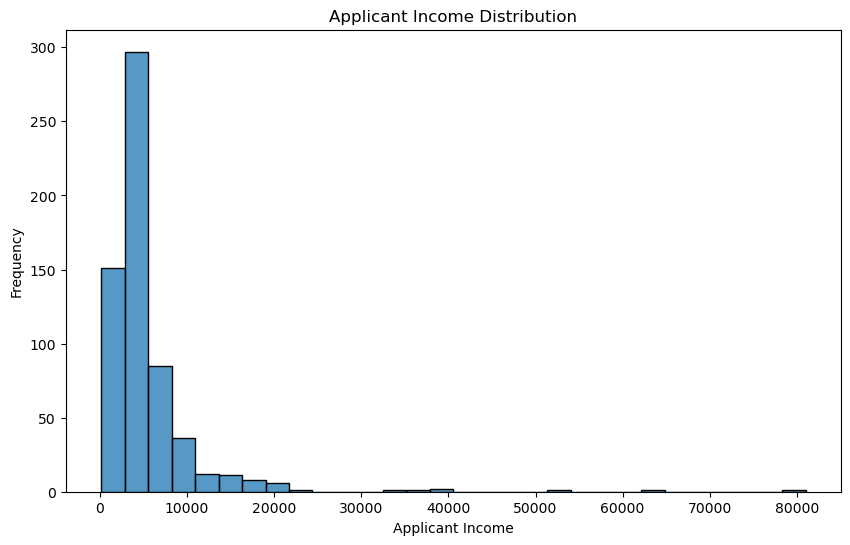

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ApplicantIncome'], bins=30, kde=False)

plt.title('Applicant Income Distribution')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()


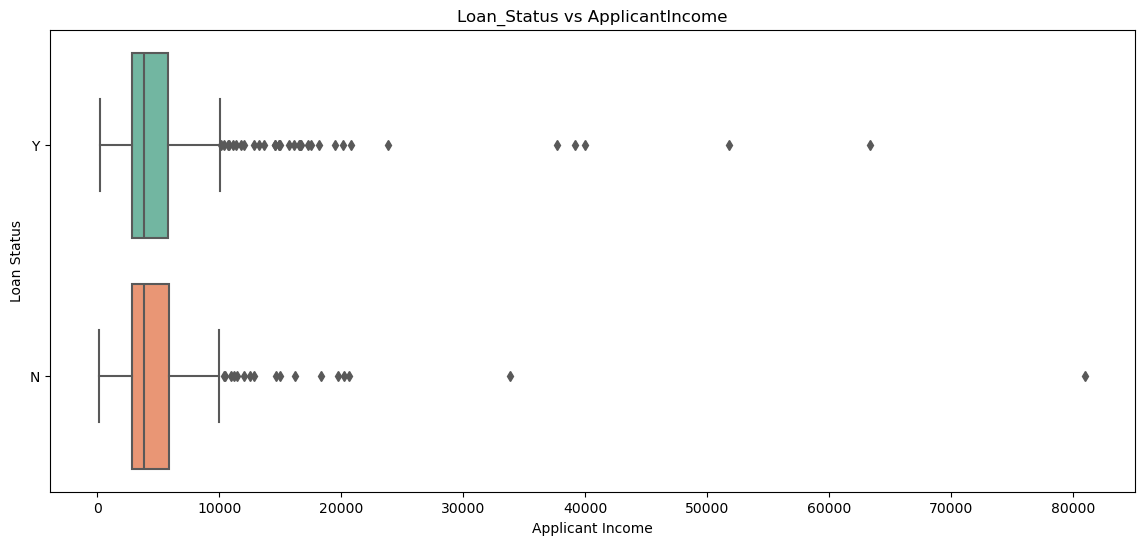

In [94]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='ApplicantIncome', y='Loan_Status', data=df, palette='Set2')

plt.title('Loan_Status vs ApplicantIncome')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Status')
plt.show()

In [95]:
# Calculate the IQR
Q1 = df['ApplicantIncome'].quantile(0.25)
Q3 = df['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['ApplicantIncome'] >= lower_bound) & (df['ApplicantIncome'] <= upper_bound)]

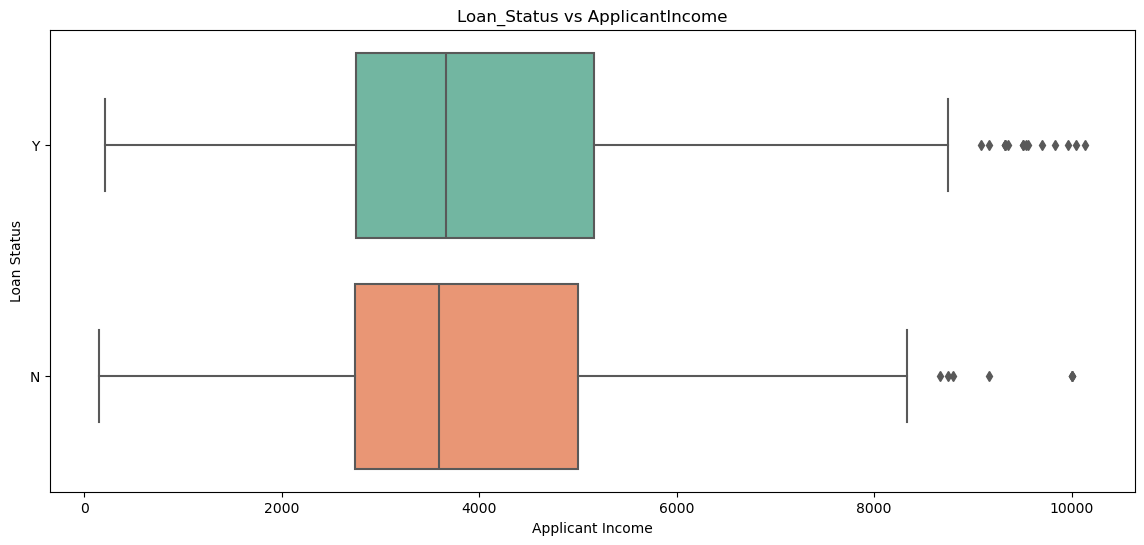

In [96]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='ApplicantIncome', y='Loan_Status', data=df, palette='Set2')

plt.title('Loan_Status vs ApplicantIncome')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Status')
plt.show()

In [97]:
# Calculate the IQR
Q1 = df['CoapplicantIncome'].quantile(0.25)
Q3 = df['CoapplicantIncome'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['CoapplicantIncome'] >= lower_bound) & (df['CoapplicantIncome'] <= upper_bound)]

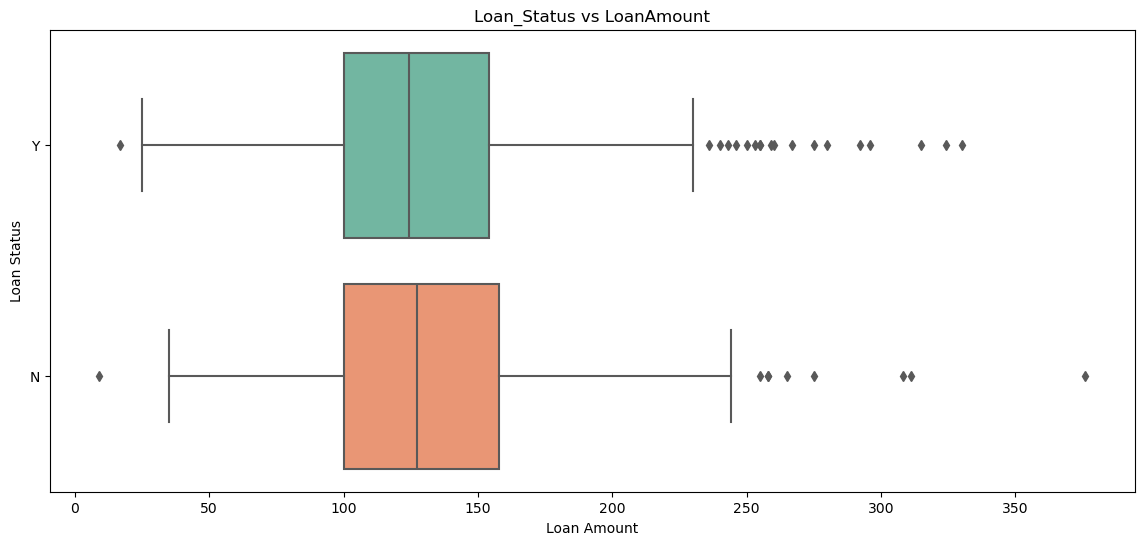

In [98]:
# Assuming `df` is your DataFrame and it contains the 'Loan_Status' and 'LoanAmount' columns
plt.figure(figsize=(14, 6))
sns.boxplot(x='LoanAmount', y='Loan_Status', data=df, palette='Set2')

plt.title('Loan_Status vs LoanAmount')
plt.xlabel('Loan Amount')
plt.ylabel('Loan Status')
plt.show()

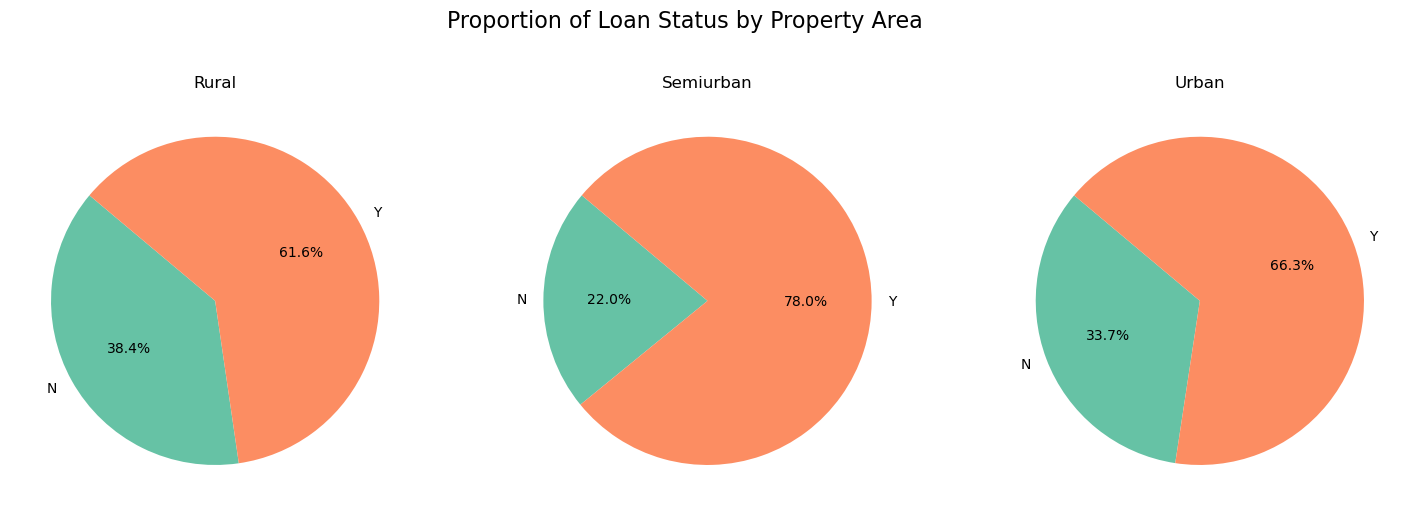

In [99]:
df_prop = df.groupby(['Property_Area', 'Loan_Status']).size().unstack().fillna(0)
df_prop = df_prop.div(df_prop.sum(axis=1), axis=0)  # Convert counts to proportions

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, property_area in enumerate(df_prop.index):
    ax = axes[i]
    proportions = df_prop.loc[property_area]
    ax.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
    ax.set_title(property_area)

# Titles and labels
fig.suptitle('Proportion of Loan Status by Property Area', fontsize=16)
plt.show()

### Ml
Data Preparation and Training Loan Approval Prediction Model
In this step, we will:

- convert categorical columns into numerical ones;
- split the data into training and test sets;
- scale the numerical features;
- train the loan approval prediction model.

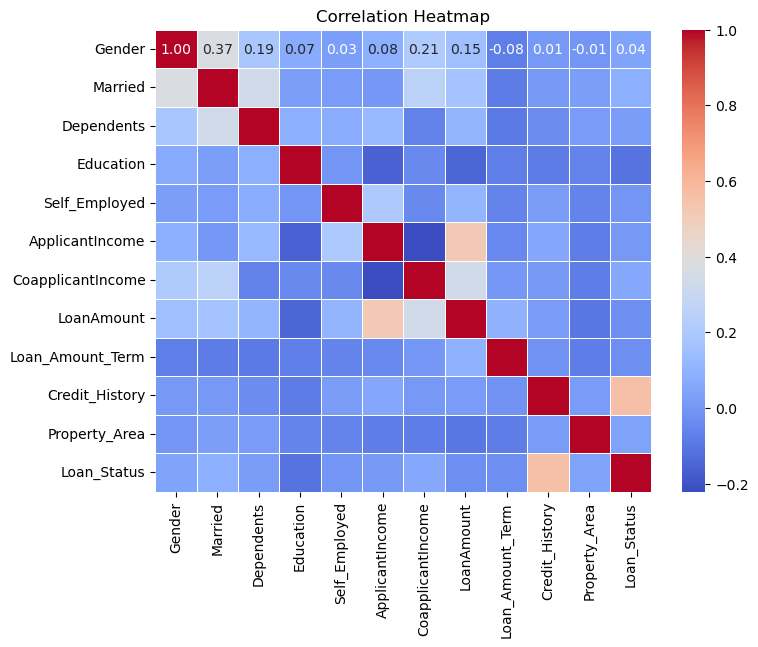

In [100]:
columns_to_analyze_3 = [
    'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'
]
# Ensure all columns are in the DataFrame
df_filtered = df[columns_to_analyze_3]

# Convert categorical variables to numeric codes
df_filtered_encoded = df_filtered.copy()
for col in df_filtered_encoded.select_dtypes(include=['object']).columns:
    df_filtered_encoded[col] = df_filtered_encoded[col].astype('category').cat.codes

# Compute the correlation matrix
correlation_matrix = df_filtered_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [101]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the performance of the given model on the test data.
    
    Parameters:
    model: Trained model object (e.g., SVC model)
    X_test: Test feature data (e.g., test set features)
    y_test: True labels for the test data (e.g., test set labels)
    """
    # Predict labels for the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.1f}')

    # Generate and print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:')
    print(conf_matrix)

    # Generate and print classification report
    class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print('\nClassification Report:')
    print(class_report)

# Example usage:
# evaluate_model(model_v1, X_test, y_test)

In [116]:
cat = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

# Criar um dicionário para armazenar encoders para cada coluna categórica
label_encoders = {}

# Aplicar o encoder em cada coluna categórica
for column in cat:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Remover valores missing se necessário
df.dropna(inplace=True)

In [117]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
# Scale the numerical columns using StandardScaler
scaler = StandardScaler()
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [119]:
model_v1 = SVC(random_state=42)

In [120]:
start = time.time()
model_v1.fit(X_train, y_train)
end = time.time()
print('Training time was\n :', end - start)

Training time was
 : 0.007395267486572266


In [121]:
forecasts_v1 = model_v1.predict(X_test)

In [122]:
evaluate_model(model_v1, X_test, y_test)

Accuracy: 0.8

Confusion Matrix:
[[ 26  29]
 [  3 107]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.47      0.62        55
     Class 1       0.79      0.97      0.87       110

    accuracy                           0.81       165
   macro avg       0.84      0.72      0.74       165
weighted avg       0.82      0.81      0.79       165



In [141]:
y_pred = model_v1.predict(X_test)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1]


In [139]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 277 to 225
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          165 non-null    float64
 1   CoapplicantIncome        165 non-null    float64
 2   LoanAmount               165 non-null    float64
 3   Loan_Amount_Term         165 non-null    float64
 4   Credit_History           165 non-null    float64
 5   Gender_Female            165 non-null    uint8  
 6   Gender_Male              165 non-null    uint8  
 7   Married_No               165 non-null    uint8  
 8   Married_Yes              165 non-null    uint8  
 9   Dependents_0             165 non-null    uint8  
 10  Dependents_1             165 non-null    uint8  
 11  Dependents_2             165 non-null    uint8  
 12  Dependents_3+            165 non-null    uint8  
 13  Education_Graduate       165 non-null    uint8  
 14  Education_Not Graduate  

In [148]:
random_test = np.array([
    [-0.541312, -0.042882, -1.008272, 0.320539, 0.396358, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
])

In [149]:
# Fazer a previsão
random_predict = model_v1.predict(random_test)

# Exibir o resultado
print("Prediction for the applicant:", "Approved" if previsao[0] == 1 else "Rejected")


Prediction for the applicant: Approved


C:\Users\nonak\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [153]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add the predicted values to X_test_df
X_test_df['Loan_Status_Predicted'] = y_pred
print(X_test_df.head())

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
277        -0.541312          -0.042882   -1.008272          0.320539   
84         -0.076835          -0.942069   -1.604671         -1.368131   
275        -0.726577           0.332009   -0.312474          0.320539   
392        -0.814224           0.520839   -0.213074          0.320539   
537        -0.271548          -0.942069   -0.471513          0.320539   

     Credit_History  Gender_Female  Gender_Male  Married_No  Married_Yes  \
277        0.396358              0            1           0            1   
84         0.396358              0            1           0            1   
275        0.396358              0            1           0            1   
392        0.396358              0            1           0            1   
537        0.396358              0            1           1            0   

     Dependents_0  ...  Dependents_2  Dependents_3+  Education_Graduate  \
277             1  ...       